# 操作1

In [98]:
%%HTML
<style>
    body {
        --vscode-font-family: 霞鹜文楷, Consolas, 'Courier New', monospace
    }
</style>

In [99]:
import warnings
warnings.filterwarnings('ignore')

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

In [101]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [102]:
from pts.model.time_grad import TimeGradEstimator
from pytorch_lightning import Trainer

In [103]:
from diffusers import DEISMultistepScheduler

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

# 数据准备

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.common import ListDataset
from gluonts.dataset.split import split
df = pd.read_csv(  "./mydata/diabetes.csv")
df_input = df[['timestamp', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7']]
df_input = df_input.set_index('timestamp')

In [107]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
train_grouper_diabetes = MultivariateGrouper(max_target_dim=8)

test_grouper_diabetes = MultivariateGrouper( max_target_dim=8)

In [108]:
train_time='2020-02-27 04:12:53'
training_data = train_grouper_diabetes([
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v1[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v2[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v3[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v4[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v5[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v6[:train_time]}],
     freq = "5min"
    )[0],ListDataset(
     [{"start": df_input.index[0], "target": df_input.v7[:train_time]}],
     freq = "5min"
    )[0],
])

In [109]:
test_data = test_grouper_diabetes([
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v1[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v2[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v3[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v4[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v5[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v6[train_time:]}],
     freq = "5min"
    )[0],ListDataset(
     [{"start": df_input.index[0], "target": df_input.v7[train_time:]}],
     freq = "5min"
    )[0],
])+test_grouper_diabetes([
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v1[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v2[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v3[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v4[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v5[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v6[train_time:]}],
     freq = "5min"
    )[0],ListDataset(
     [{"start": df_input.index[0], "target": df_input.v7[train_time:]}],
     freq = "5min"
    )[0],
])

In [110]:
scheduler = DEISMultistepScheduler(
    num_train_timesteps=150,
    beta_end=0.1,
)

In [111]:
estimator_Diabetes = TimeGradEstimator(
    input_size=7,
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=12,
    context_length=36,
    freq='5min',
    scaling="mean",
    trainer_kwargs=dict(max_epochs=1, accelerator="gpu", devices="1"),
)


# 训练开始

In [112]:
predictor_Diabetes = estimator_Diabetes.train(training_data, num_workers=8)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


INFO: 
  | Name  | Type          | Params | Mode  | In sizes                                                         | Out sizes      
-------------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 73.1 K | train | [[1, 1], [1, 1], [1, 36, 6], [1, 36, 7], [1, 36, 7], [1, 12, 6]] | [1, 100, 12, 7]
-------------------------------------------------------------------------------------------------------------------------------------
73.1 K    Trainable params
0         Non-trainable params
73.1 K    Total params
0.292     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type          | Params | Mode  | In sizes                                                         | Out sizes      
-------------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 7

Epoch 0: |          | 50/? [00:04<00:00, 10.05it/s, v_num=23, train_loss=0.360]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.36038 (best 0.36038), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_23/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: |          | 50/? [00:05<00:00,  9.93it/s, v_num=23, train_loss=0.360]


In [113]:
forecast_it_Diabetes, ts_it_Diabetes = make_evaluation_predictions(dataset=test_data,
                                                 predictor=predictor_Diabetes,
                                                 num_samples=10)


In [114]:
forecasts_Diabetes = list(forecast_it_Diabetes)
targets_Diabetes = list(ts_it_Diabetes)

In [115]:
len(forecasts_Diabetes)

2

In [123]:
train_time

'2020-02-27 04:12:53'

In [136]:
forecasts_Diabetes[0].samples[1]

array([[-1.32095938e+01,  5.52777863e+00,  9.50003326e-01,
        -2.63971024e+01, -2.20536280e+00,  5.01301003e+00,
        -7.65994358e+00],
       [ 1.26550865e+01,  2.47252524e-01, -4.29885960e+00,
        -6.33176470e+00, -4.20123339e+00, -1.86562657e+00,
        -3.60736513e+00],
       [-3.35973430e+00,  5.60817897e-01,  5.91358006e-01,
        -2.13706255e+00, -2.13677192e+00,  2.03567004e+00,
         8.77658010e-01],
       [-7.63503981e+00,  2.74083400e+00, -3.05314183e-01,
        -4.21717978e+00, -9.80048597e-01,  3.09807277e+00,
        -1.09535408e+01],
       [ 2.01010466e+00,  4.43083532e-02, -2.84808934e-01,
         6.76882863e-01, -6.23019397e-01, -1.37244380e+00,
        -2.24106765e+00],
       [-1.02055454e+01, -9.95367587e-01,  1.03293109e+00,
        -1.44409150e-01, -7.59803653e-01,  2.22857878e-01,
        -1.42682493e+00],
       [ 5.04322767e-01, -7.52095342e-01, -1.61141455e-01,
         4.79238701e+00, -1.11358047e-01, -2.04579043e+00,
         2.6071195

In [133]:
targets_Diabetes[0]

,0,1,2,3,4,5,6
2020-02-26 21:42,-0.647059,0.135678,-0.278689,-0.737374,0.000000,-0.332340,-0.947054
2020-02-26 21:47,-0.764706,-0.256281,0.000000,0.000000,0.000000,0.000000,-0.979505
2020-02-26 21:52,-0.176471,-0.165829,0.278689,-0.474747,-0.832151,-0.126677,-0.411614
2020-02-26 21:57,0.000000,0.015075,0.065574,-0.434343,0.000000,-0.266766,-0.864219
2020-02-26 22:02,-0.411765,0.376884,0.770492,0.000000,0.000000,0.454545,-0.872758
2020-02-26 22:07,-0.764706,0.105528,0.213115,-0.414141,-0.704492,-0.034277,-0.470538
2020-02-26 22:12,0.529412,0.065327,0.180328,0.090909,0.000000,0.090909,-0.914603
2020-02-26 22:17,-0.764706,0.005025,0.114754,-0.494949,-0.832151,0.147541,-0.789923
2020-02-26 22:22,0.764706,0.366834,0.147541,-0.353535,-0.739953,0.105812,-0.935952
2020-02-26 22:27,-0.882353,0.075377,0.114754,-0.616162,0.000000,-0.210134,-0.925705


In [132]:
targets_Diabetes[1]

,0,1,2,3,4,5,6
2020-02-26 21:42,-0.647059,0.135678,-0.278689,-0.737374,0.000000,-0.332340,-0.947054
2020-02-26 21:47,-0.764706,-0.256281,0.000000,0.000000,0.000000,0.000000,-0.979505
2020-02-26 21:52,-0.176471,-0.165829,0.278689,-0.474747,-0.832151,-0.126677,-0.411614
2020-02-26 21:57,0.000000,0.015075,0.065574,-0.434343,0.000000,-0.266766,-0.864219
2020-02-26 22:02,-0.411765,0.376884,0.770492,0.000000,0.000000,0.454545,-0.872758
2020-02-26 22:07,-0.764706,0.105528,0.213115,-0.414141,-0.704492,-0.034277,-0.470538
2020-02-26 22:12,0.529412,0.065327,0.180328,0.090909,0.000000,0.090909,-0.914603
2020-02-26 22:17,-0.764706,0.005025,0.114754,-0.494949,-0.832151,0.147541,-0.789923
2020-02-26 22:22,0.764706,0.366834,0.147541,-0.353535,-0.739953,0.105812,-0.935952
2020-02-26 22:27,-0.882353,0.075377,0.114754,-0.616162,0.000000,-0.210134,-0.925705


# 画出预测图

Diabetes


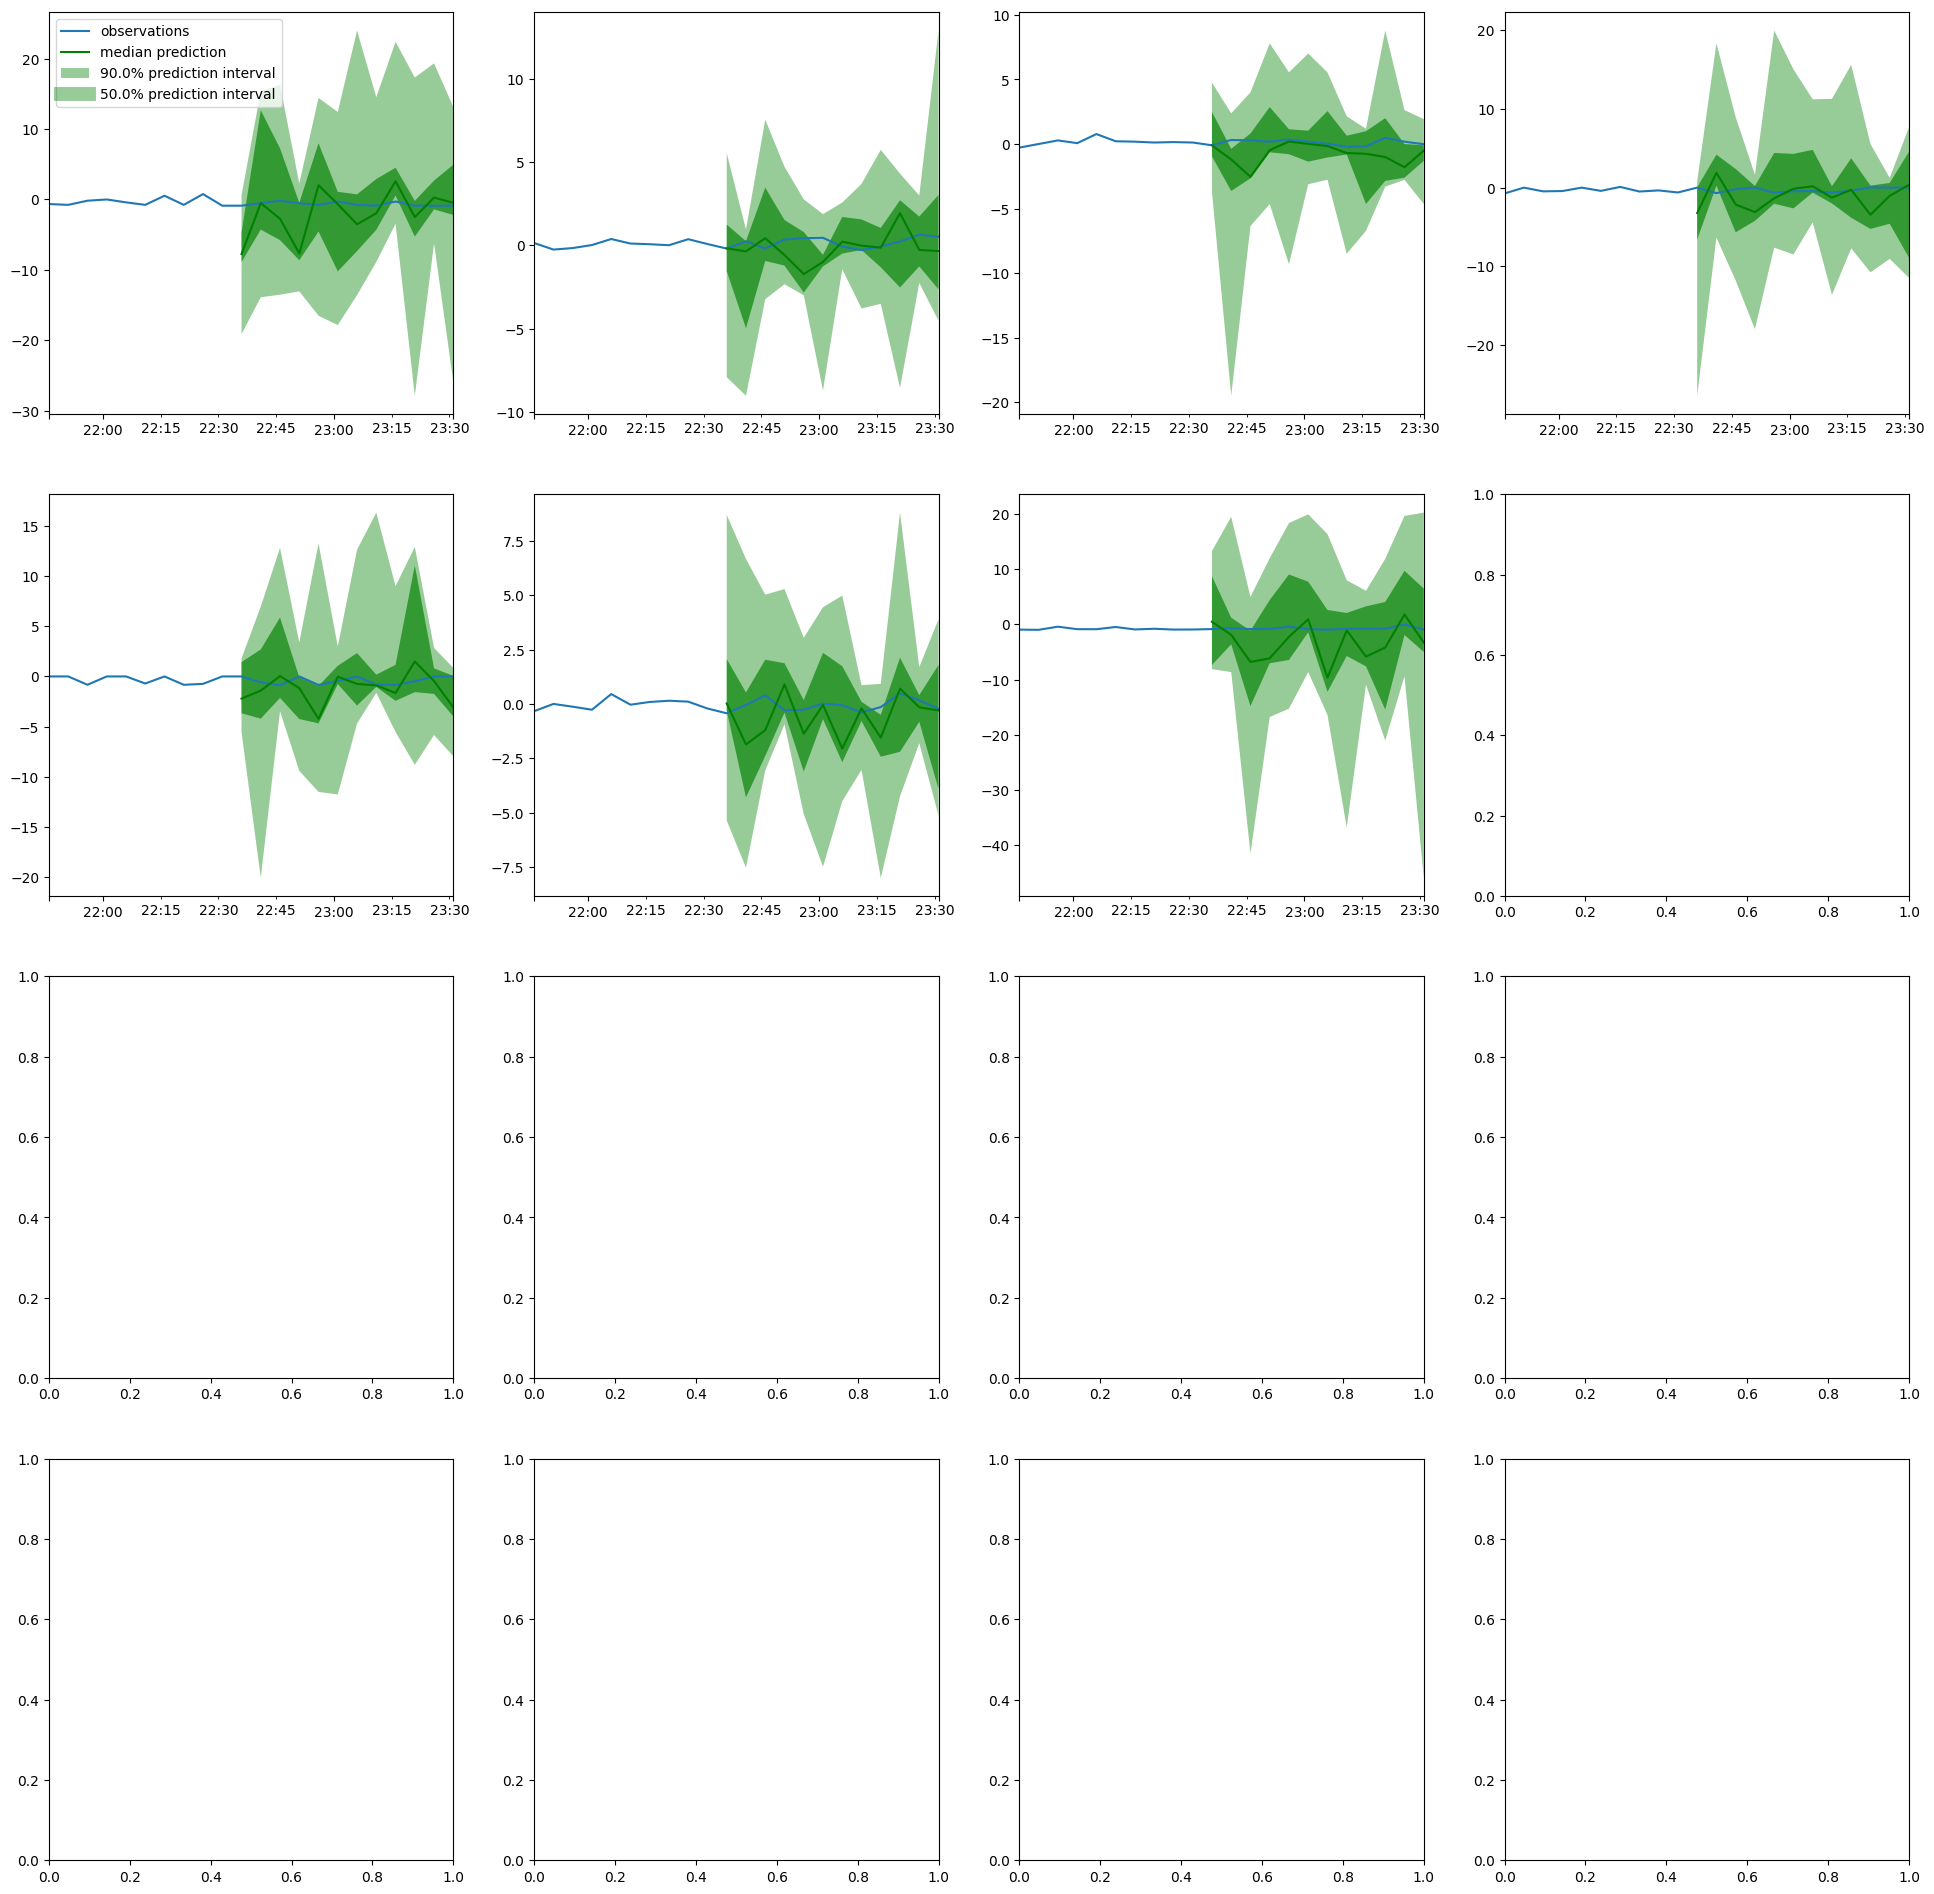

In [119]:
print("Diabetes")

plot(
    target=targets_Diabetes[0],
    forecast=forecasts_Diabetes[0],
    prediction_length=12,
)
plt.show()

# 评估

In [120]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [121]:
agg_metric_Diabetes, item_metrics_Diabetes = evaluator(targets_Diabetes, forecasts_Diabetes, num_series=len(test_data))


Running evaluation: 2it [00:00, 62.57it/s]
Running evaluation: 0it [00:00, ?it/s]

Running evaluation: 2it [00:00, 111.50it/s]
Running evaluation: 2it [00:00, 111.42it/s]
Running evaluation: 2it [00:00, 116.54it/s]
Running evaluation: 2it [00:00, 116.85it/s]
Running evaluation: 2it [00:00, 115.49it/s]
Running evaluation: 2it [00:00, 127.09it/s]
Running evaluation: 2it [00:00, 121.71it/s]


In [122]:
print("Diabetes Results")
print("CRPS:", agg_metric_Diabetes["mean_wQuantileLoss"])
print("ND:", agg_metric_Diabetes["ND"])
print("NRMSE:", agg_metric_Diabetes["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric_Diabetes["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric_Diabetes["m_sum_ND"])
print("NRMSE-Sum:", agg_metric_Diabetes["m_sum_NRMSE"])

Diabetes Results
CRPS: 3.3334521616253965
ND: 3.605343395647132
NRMSE: 5.6619707432151465

CRPS-Sum: 1.728138353300316
ND-Sum: 2.2061316085131097
NRMSE-Sum: 2.9844633657562336
